In [1]:
import pandas as pd
import numpy as np
import json
import folium

In [10]:
test = {'value': [0.1, 0.0, 0.8, 1.4, 2.3, 1.1, 1.0, 2.0]}
df = pd.DataFrame(test)
bins = np.linspace(min(df['value']), max(df['value']), 4)
group_names = ['0-1', '1-2', '2-3']
df['value_binned'] = pd.cut(df['value'], bins, labels = group_names, include_lowest=True)
df

value value_binned
0    0.1          0-1
1    0.0          0-1
2    0.8          1-2
3    1.4          1-2
4    2.3          2-3
5    1.1          1-2
6    1.0          1-2
7    2.0          2-3

# Correspondance between 2016 and 2020 FSA

The FSA have evolved since the census in 2016. The main part of the FSA is similar, but some of them have changed. So, we will group them in order to have similar territories for the data from 2016 and the data from 2020.

In [11]:
def process_fsa(fsa, year):
    if year == 2020:
        fsas = {'H3A': 'H3A-H3B', 'H3B': 'H3A-H3B',
                'H8S': 'H8S-H8T', 'H8T': 'H8S-H8T',
                'H9J': 'H9J-H9K', 'H9K': 'H9J-H9K',
                'H4Y': 'H9P', 'H9P': 'H9P',
                'H5B': 'H2Z',
                'H5A': 'H3A-H3B', 'H4Z': 'H3A-H3B',
                'H4R': 'H4R-H4S-H4T', 'H4S': 'H4R-H4S-H4T', 'H4T': 'H4R-H4S-H4T'}
    if year == 2016:
        fsas = {'H3A': 'H3A-H3B', 'H3B': 'H3A-H3B',
                'H8S': 'H8S-H8T', 'H8T': 'H8S-H8T',
                'H9J': 'H9J-H9K', 'H9K': 'H9J-H9K',
                'H4R': 'H4R-H4S-H4T', 'H4S': 'H4R-H4S-H4T'}
    if fsa in fsas:
        return fsas[fsa]
    else:
        return fsa

# Foursquare

In [132]:
# Export the foursquare dataset
foursquare = pd.read_csv('../data/foursquare/all.csv')

# Drop duplicates
foursquare.drop_duplicates(subset = 'id', inplace=True, ignore_index=True)

# Process the data to group categories
def process_categories(category_name):
    
    # Restaurant and Bar
    restaurant = ['restaurant', 'bar', 'café', 'cafe', 'coffee', 'pizza', 'sandwich', 'breakfast spot', 'ice cream',
                  'frozen yogurt', 'speakeasy', 'nightlife', 'diner', 'lounge', 'joint', 'snack', 'bistro', 'food truck',
                  'brewery', 'strip club', 'pub', 'nightclub', 'food court', 'steakhouse', 'tea room', 'taco', 'castle',
                  'creperie', 'buffet', 'food service', 'bath house', 'poke place', 'soup place', 'club house',
                  'fish & chips', 'burrito', 'poutine', 'noodle', 'brasserie', 'well', 'salad place', 'beer garden']
    for r in restaurant:
        if r in str(category_name).lower() and str(category_name) not in ['Salon / Barbershop', 'Piano Bar', 'Public Art']:
            return 'RestaurantBar'
    
    # Entertainment
    entertainment = ['museum', 'theater', 'entertainment', 'event space', 'art gallery', 'performing', 'public art',
                     'art studio', 'library', 'design', 'music venue', 'comedy', 'photography', 'sculpture',
                     'convention center', 'arcade', 'bowling', 'recreation', 'rock', 'jazz', 'concert', 'auditorium',
                     'water', 'monument', 'lighthouse', 'exhibit', 'planetarium', 'recording studio', 'memorial site',
                     'piano', 'circus', 'zoo', 'massage', 'casino', 'play area']
    for e in entertainment:
        if e in str(category_name).lower() and 'college' not in str(category_name).lower() or str(category_name) == 'Spa':
            return 'EntertainmentCulture'
    
    # Services
    services = ['store', 'shop', 'service', 'pharmacy', 'bank', 'bakery', 'gas station', 'government', 'bodega',
                'salon', 'post', 'rental car', 'veterinarian', 'boutique', 'car wash', 'tattoo', 'butcher', 'real estate',
                'auto', 'storage', 'market', 'parking', 'atm', 'lawyer', 'funeral', 'food', 'cleaner', 'embassy',
                'driving', 'agency', 'courthouse', 'repair', 'winery', 'grocery', 'animal', 'notary', 'food stand',
                'credit union', 'locksmith', 'laundromat', 'general travel']
    for s in services:
        if s in str(category_name).lower():
            return 'Services'
    
    # Sports
    sports = ['pool', 'gym', 'sports', 'field', 'studio', 'court', 'rink', 'golf', 'arena', 'track', 'stadium',
              'skate', 'range', 'dojo', 'curling']
    for s in sports:
        if s in str(category_name).lower():
            return 'Sports'
    
    # Outdoor
    outdoor = ['park', 'outdoor', 'scenic lookout', 'site', 'garden', 'marina', 'boat', 'plaza', 'trail', 'mountain', 'surf',
               'campground', 'lake', 'beach', 'rest area', 'vineyard', 'forest', 'nature', 'cave', 'fishing', 'rafting']
    for o in outdoor:
        if o in str(category_name).lower():
            return 'Outdoor'
    
#     # Medical
#     medical = ['dentist', 'doctor', 'medical', 'hospital', 'assisted living', 'chiropractor', 'mental', 'healer',
#                'emergency', 'therapist', 'laboratory', 'acupuncturist', 'clinic']
#     for m in medical:
#         if m in str(category_name).lower():
#             return 'Medical'
    
#     # Religious
#     religious = ['church', 'synagogue', 'temple', 'spiritual', 'mosque', 'shrine']
#     for r in religious:
#         if r in str(category_name).lower():
#             return 'Religious'
    
    # All other
    if pd.isna(category_name):
        category = 'Other'

    return 'Other'

foursquare['Category'] = foursquare['category_name'].apply(process_categories)
# Process the FSA to make correspondance between 2016 and 2020
foursquare['FSA'] = foursquare['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by categories to get the number of venues for each category per FSA
foursquare = foursquare[['FSA', 'id', 'Category']].groupby(['FSA', 'Category']).agg(NbVenue=('id','count')).reset_index()
foursquare.head()

FSA              Category  NbVenue
0  H1A  EntertainmentCulture        3
1  H1A                 Other       39
2  H1A               Outdoor       10
3  H1A         RestaurantBar        7
4  H1A              Services       29

# STM

In [13]:
# Read the CSV file with the metro stations per FSA
metro_stations = pd.read_csv('../data/metro/metro_stations.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
metro_stations['FSA'] = metro_stations['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of stations per FSA
metro_stations = metro_stations.groupby(['FSA']).agg(MetroStations=('Name', 'count')).reset_index()
metro_stations.head()

FSA  MetroStations
0  H1L              1
1  H1N              4
2  H1V              1
3  H1W              3
4  H2A              1

# Daycare

In [82]:
# Get the data from the CSV file
daycare = pd.read_csv('../data/daycare/liste-des-services-de-garde-07.csv', engine='python')

# Keep only the daycares in the Montreal island
def mtl_fsa(postal_code):
    if postal_code[0:2] in ['H1', 'H2', 'H3', 'H4', 'H5', 'H8', 'H9']:
        return True
    else:
        return False
daycare = daycare[daycare['CODE_POSTAL_COMPO'].apply(mtl_fsa)].reset_index(drop=True)
daycare['FSA'] = daycare['CODE_POSTAL_COMPO'].apply(lambda x: x[0:3])

# Process the FSA to make correspondance between 2016 and 2020
daycare['FSA'] = daycare['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of daycares per FSA
daycare = daycare.groupby(['FSA']).agg(Daycare=('ADRESSE','count')).reset_index()
daycare.head()

FSA  Daycare
0  H1A       14
1  H1B       10
2  H1C        8
3  H1E       28
4  H1G       26

# Schools

In [14]:
# Get the data from the CSV files
college = pd.read_csv('../data/schools/ES_Collegial.csv', sep=';')
univ = pd.read_csv('../data/schools/ES_Universitaire.csv', sep=';')
pps_gouv = pd.read_csv('../data/schools/PPS_Gouvernemental.csv', sep=';')
pps_prive = pd.read_csv('../data/schools/PPS_Prive_Installation.csv', sep=';')
pps_public = pd.read_csv('../data/schools/PPS_Public_Ecole.csv', sep=';')
pps_public.rename(columns={'CD_POSTL_GDUNO_ORGNS': 'CD_POSTL_GDUNO'}, inplace=True)

# Keep only the schools in the Montreal island
def mtl_fsa(postal_code):
    if postal_code[0:2] in ['H1', 'H2', 'H3', 'H4', 'H5', 'H8', 'H9']:
        return True
    else:
        return False
college = college[college['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
univ = univ[univ['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_gouv = pps_gouv[pps_gouv['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_prive = pps_prive[pps_prive['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_public = pps_public[pps_public['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)

# Duplicate rows with multiple school levels and separate the name to have one row for one school level
def school_level(school):
    for i in school.index:
        s = school.loc[i, 'ORDRE_ENS'].split('-')
        if len(s) > 1:
            for j in range(1, len(s)):
                m = max(school.index)+1
                school.loc[m] = school.loc[i]
                school.loc[m, 'ORDRE_ENS'] = s[j]
                if school.loc[m, 'ORDRE_ENS'][0] == ' ':
                    school.loc[m, 'ORDRE_ENS'] = school.loc[m, 'ORDRE_ENS'][1:]
                if school.loc[m, 'ORDRE_ENS'][-1] == ' ':
                    school.loc[m, 'ORDRE_ENS'] = school.loc[m, 'ORDRE_ENS'][:-1]
            school.loc[i, 'ORDRE_ENS'] = s[0]
            school.loc[i, 'ORDRE_ENS'] = school.loc[i, 'ORDRE_ENS'][:-1]
    school.sort_values(by=['OBJECTID'], inplace=True)
    school.reset_index(drop=True, inplace=True)
    return school
pps_prive = school_level(pps_prive)
pps_public = school_level(pps_public)

# Create a dataframe containing all the schools with the FSA and the school level
schools = pd.concat([college[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     univ[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_gouv[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_prive[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_public[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']]])
schools['CD_POSTL_GDUNO'] = schools['CD_POSTL_GDUNO'].apply(lambda x: x[0:3])
schools.rename(columns={'OBJECTID': 'SchoolId', 'CD_POSTL_GDUNO': 'FSA', 'ORDRE_ENS': 'Level'}, inplace=True)

# Classify the school level into three categories: PPS (Preschool, Primary school and Secondary school),
# Post-secondary and Professional Formation - Adult Education
def classify_school_levels(level):
    if level in ['Préscolaire', 'Primaire', 'Secondaire']:
        return 'PPS'
    if level in ['Collégial', 'Universitaire']:
        return 'PostSecondary'
    if level in ['Éducation aux adultes', 'Formation professionnelle']:
        return 'ProfessionalFormation-AdultEducation'
schools['SchoolType'] = schools['Level'].apply(classify_school_levels)
schools.sort_values(by=['FSA'], inplace=True)

# Process the FSA to make correspondance between 2016 and 2020
schools['FSA'] = schools['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of schools (for each category) per FSA
schools = schools.groupby(['FSA', 'SchoolType']).agg(NbSchool=('SchoolId','count')).reset_index()
schools.head()

FSA                            SchoolType  NbSchool
0  H1A                                   PPS        23
1  H1B                                   PPS        16
2  H1B  ProfessionalFormation-AdultEducation         6
3  H1C                                   PPS        14
4  H1E                                   PPS        15

# Walkscore

Let's see all the available and not available walkscores, transitscores and bikescores on the map.

In [15]:
# Data for Montreal
latitude = 45.505331312
longitude = -73.55249779
mtl_geo_json = "../data/maps/mtl_fsa_map.geojson"
mtl_grp_geo_json = "../data/maps/mtl_fsa_grouped_map.geojson"

# Get the walkscore data
ws = pd.read_csv('../data/walkscore/walkscore.csv', index_col=0)

# Choose the score to visualize
score = 'Walkscore' # 'Walkscore' or 'Transitscore' or 'Bikescore'

# Built the map
nan_ws_map = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, score in zip(ws['Latitude'], ws['Longitude'], ws[score]):
    label = folium.Popup(str(score), parse_html=True)
    if np.isnan(score):
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='red',
            parse_html=False).add_to(nan_ws_map)
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='blue',
            parse_html=False).add_to(nan_ws_map)
nan_ws_map

The available walkscores and bikescores can be processed but the transitscores are not relevant because they are too concentrated on a single geographic area.

In [16]:
# Process the FSA to make correspondance between 2016 and 2020
ws['FSA'] = ws['FSA'].apply(lambda x: process_fsa(x, 2016))
# Get the mean score for each FSA
walkscore = ws.groupby('FSA', as_index=False).mean()
# Drop the transitscore because it is not relevant
walkscore.drop(columns='Transitscore', inplace=True)
walkscore.rename(columns={'Walkscore': 'WalkscoreValue',
                          'Bikescore': 'BikescoreValue'}, inplace=True)

# Get the description associated with the score
def score_description(score, score_type):
    description = {'Walkscore': ['Car-dependent+', 'Car-dependent', 'SomewhatWalkable',
                                  'VeryWalkable', 'WalkersParadise'],
                    'Bikescore': ['SomewhatBikeable', 'SomewhatBikeable', 'Bikeable',
                                  'VeryBikeable', 'BikersParadise']}
    if score < 25:
        return description[score_type][0]
    if score >= 25 and score < 50:
        return description[score_type][1]
    if score >= 50 and score < 70:
        return description[score_type][2]
    if score >= 70 and score < 90:
        return description[score_type][3]
    if score >= 90 and score <= 100:
        return description[score_type][4]

score_types = ['Walkscore', 'Bikescore']
for score_type in score_types:
    walkscore[score_type] = walkscore[score_type + 'Value'].apply(lambda x: score_description(x, score_type))
walkscore.head()

FSA   Latitude  Longitude  WalkscoreValue  BikescoreValue       Walkscore  \
0  H1A  45.670741 -73.505878       19.733766       54.967532  Car-dependent+   
1  H1B  45.635377 -73.523538       15.466165       47.318182  Car-dependent+   
2  H1C  45.669124 -73.534936        3.850877       47.157895  Car-dependent+   
3  H1E  45.638857 -73.583131       31.719298       54.719298   Car-dependent   
4  H1G  45.612047 -73.620212       49.437500       60.137500   Car-dependent   

          Bikescore  
0          Bikeable  
1  SomewhatBikeable  
2  SomewhatBikeable  
3          Bikeable  
4          Bikeable

Let's see the choropleth map of Montreal for the walkscores and bikescores:

In [17]:
score = 'WalkscoreValue' # 'WalkscoreValue' or 'BikescoreValue'
bins = {'WalkscoreValue': [0, 25, 50, 70, 90, 100],
        'BikescoreValue': [0, 50, 70, 90, 100]}

ws_map = folium.Map(location=[latitude, longitude], zoom_start=10)
label = folium.Popup(score, parse_html=True)
folium.Choropleth(
    geo_data=mtl_grp_geo_json,
    data=walkscore,
    columns=['FSA', score],
    key_on='feature.properties.FSAGROUP',
    fill_color='BuPu',
    fill_opacity=0.8, 
    line_opacity=0.2,
    bins=bins[score],
    legend_name=score,
    popup=label
).add_to(ws_map)

ws_map

Walkscore:
- 0-25: Car-dependent *(almost all errands require a car)*
- 25-50: Car-dependent *(most errands require a car)*
- 50-70: Somewhat walkable *(some errands can be accomplished on foot)*
- 70-90: Very walkable *(most errands can be accomplished on foot)*
- 90-100: Walker's paradise *(daily errands do not require a car)*

Bikescore:
- 0-50: Somewhat bikeable *(minimal bike infrastructure)*
- 50-70: Bikeable *(some bike infrastructure)*
- 70-90: Very bikeable *(biking is convenient for most trips)*
- 90-100: Biker's paradise *(daily errands can be accomplished on a bike)*

# Creating the master dataframes

In [133]:
# Get the FSA with their areas to create the master dataframe for the FSA environment
df_env = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_env['FSA'] = df_env['FSA'].apply(lambda x: process_fsa(x, 2020))
df_env = df_env.groupby('FSA', as_index=False).sum()

# Add the walkscores and bikescores to the dataframe
df_env = df_env.join(walkscore[['FSA', 'Walkscore', 'Bikescore']].set_index('FSA'), on='FSA')

# Add the foursquare venues
categories = ['RestaurantBar', 'EntertainmentCulture', 'Services', 'Sports', 'Outdoor']
for category in categories:
    df = foursquare[foursquare['Category'] == category][['FSA', 'NbVenue']]
    df_env = df_env.join(df.rename(columns={'NbVenue': category}).set_index('FSA'), on='FSA')
    # Get the density instead of the number for a better comparison
    df_env[category] = df_env[category] / df_env['Area(km2)']

# Add the metro stations
df_env = df_env.join(metro_stations.set_index('FSA'), on='FSA')
# Get the density instead of the number for a better comparison
df_env['MetroStations'] = df_env['MetroStations'] / df_env['Area(km2)']

# Add the daycares
df_env = df_env.join(daycare.set_index('FSA'), on='FSA')
# Get the density instead of the number for a better comparison
df_env['Daycare'] = df_env['Daycare'] / df_env['Area(km2)']

# Add the schools
school_types = ['PPS', 'PostSecondary']
for school_type in school_types:
    df = schools[schools['SchoolType'] == school_type][['FSA', 'NbSchool']]
    df_env = df_env.join(df.rename(columns={'NbSchool': school_type}).set_index('FSA'), on='FSA')
    # Get the density instead of the number for a better comparison
    df_env[school_type] = df_env[school_type] / df_env['Area(km2)']

df_env.round(2).head()

FSA  Area(km2)       Walkscore         Bikescore  RestaurantBar  \
0  H1A       15.2  Car-dependent+          Bikeable           0.46   
1  H1B       13.4  Car-dependent+  SomewhatBikeable           1.87   
2  H1C       11.2  Car-dependent+  SomewhatBikeable           0.71   
3  H1E       11.1   Car-dependent          Bikeable           2.70   
4  H1G        7.9   Car-dependent          Bikeable           2.41   

   EntertainmentCulture  Services  Sports  Outdoor  MetroStations  Daycare  \
0                  0.20      1.91    0.53     0.66            NaN     0.92   
1                  0.67      2.69    0.07     0.45            NaN     0.75   
2                  0.36      3.75    0.18     0.45            NaN     0.71   
3                  0.36      3.69    0.36     0.18            NaN     2.52   
4                  0.51      8.23    0.38     0.13            NaN     3.29   

    PPS  PostSecondary  
0  1.51            NaN  
1  1.19            NaN  
2  1.25            NaN  
3  1.35            NaN  
4  3.16           0.38

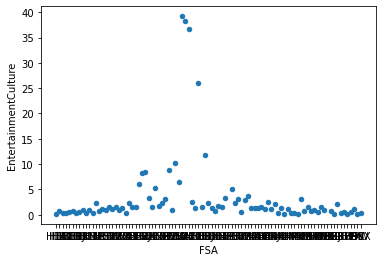

In [134]:
df_env.plot(x='FSA', y='EntertainmentCulture', kind='scatter')

In [146]:
df_env[(df_env['EntertainmentCulture'] > 1) & (df_env['EntertainmentCulture'] < 3)]

FSA  Area(km2)         Walkscore         Bikescore  RestaurantBar  \
12  H1R      4.632  SomewhatWalkable          Bikeable       2.158895   
14  H1T      4.136  SomewhatWalkable      VeryBikeable       5.560928   
16  H1W      3.142      VeryWalkable    BikersParadise       7.956715   
17  H1X      2.839      VeryWalkable      VeryBikeable       3.874604   
18  H1Y      2.642      VeryWalkable      VeryBikeable       9.462528   
20  H2A      2.237      VeryWalkable      VeryBikeable      11.175682   
22  H2C      2.671      VeryWalkable      VeryBikeable      11.231748   
23  H2E      1.915      VeryWalkable      VeryBikeable      13.054830   
24  H2G      2.005      VeryWalkable    BikersParadise      19.451372   
29  H2M      3.373  SomewhatWalkable      VeryBikeable       6.225912   
31  H2P      1.682      VeryWalkable      VeryBikeable      16.052319   
32  H2R      2.191      VeryWalkable    BikersParadise      10.953902   
41  H3C      4.852     Car-dependent          Bikeable       5.358615   
42  H3E      3.796     Car-dependent      VeryBikeable       2.634352   
44  H3H      3.739  SomewhatWalkable          Bikeable       2.139610   
46  H3K      4.443     Car-dependent      VeryBikeable       4.726536   
47  H3L      3.836  SomewhatWalkable      VeryBikeable       5.735141   
49  H3N      1.666      VeryWalkable      VeryBikeable      19.807923   
50  H3P      2.736  SomewhatWalkable      VeryBikeable       4.020468   
54  H3V      1.793     Car-dependent  SomewhatBikeable       6.134969   
57  H3Y      2.469  SomewhatWalkable          Bikeable       5.670312   
59  H4A      3.032      VeryWalkable      VeryBikeable       7.915567   
60  H4B      3.095  SomewhatWalkable      VeryBikeable       9.693053   
61  H4C      3.892     Car-dependent      VeryBikeable       7.708119   
62  H4E      4.583  SomewhatWalkable      VeryBikeable       5.236744   
63  H4G      2.785      VeryWalkable    BikersParadise      11.849192   
64  H4H      3.128     Car-dependent      VeryBikeable       2.557545   
65  H4J      2.838     Car-dependent      VeryBikeable       4.580691   
66  H4K      4.426    Car-dependent+          Bikeable       1.807501   
68  H4M      2.295     Car-dependent          Bikeable       5.664488   
70  H4P      5.100     Car-dependent          Bikeable       2.745098   
76  H8P      4.376     Car-dependent          Bikeable       2.742230   
80  H8Z      4.480     Car-dependent          Bikeable       3.794643   
85  H9G      4.127     Car-dependent          Bikeable       7.026896   
90  H9S      9.400     Car-dependent          Bikeable       1.489362   

    EntertainmentCulture   Services    Sports   Outdoor  MetroStations  \
12              2.374784  10.794473  0.647668  1.295337            NaN   
14              1.208897   8.220503  0.483559  1.208897            NaN   
16              1.591343  18.777849  0.636537  0.636537       0.954806   
17              1.056710  11.976048  1.408947  3.522367            NaN   
18              1.514005  20.439061  0.757002       NaN            NaN   
20              1.341082  18.775145  4.470273  1.341082       0.447027   
22              2.246350  21.340322  0.748783  0.748783       0.374392   
23              1.566580  28.720627       NaN  0.522193       1.566580   
24              1.496259  26.433915       NaN       NaN            NaN   
29              1.482360   8.894160  2.964720  1.482360       0.296472   
31              1.783591  16.646849  0.594530  0.594530            NaN   
32              2.282063  13.692378  0.912825  1.369238       1.369238   
41              2.473207   2.679308  0.412201  3.091509       0.206101   
42              1.317176   3.424658  5.532139  3.688093            NaN   
44              1.604707   4.279219  2.139610  1.872158            NaN   
46              2.250731   6.302048  0.675219  2.250731       0.225073   
47              1.303441   8.863399       NaN  0.521376            NaN   
49              1.800720  22.208884  4.2016

In [144]:
df_env[df_env['FSA'] == 'H2R']

FSA  Area(km2)     Walkscore       Bikescore  RestaurantBar  \
32  H2R      2.191  VeryWalkable  BikersParadise      10.953902   

    EntertainmentCulture   Services    Sports   Outdoor  MetroStations  \
32              2.282063  13.692378  0.912825  1.369238       1.369238   

      Daycare       PPS  PostSecondary  
32  10.953902  2.738476            NaN

# Cleaning Walkscore

In [185]:
def get_fsa_points(fsa):
    # Get the coordinates for the generated points
    folder_path = '../data/walkscore/FSApoints'
    read_data = []
    for (dirpath, dirnames, filenames) in os.walk(folder_path):
        if fsa is not None:
            filenames = ['{}.geojson'.format(fsa)]
        for file_name in filenames:
            with open(os.path.join(dirpath, file_name)) as f:
                read_data.append(json.load(f))
    data = []
    for f in read_data:
        fsa = f['name']
        for feature in f['features']:
            if feature['geometry'] is not None:
                point = {}
                point['fsa'] = fsa
                point['latitude'] = feature['geometry']['coordinates'][1]
                point['longitude'] = feature['geometry']['coordinates'][0]
                data.append(point)

    return data

In [186]:
points = pd.DataFrame(get_fsa_points(None))
points

fsa   latitude  longitude
0     H1A  45.672993 -73.501745
1     H1A  45.699057 -73.507709
2     H1A  45.646386 -73.534093
3     H1A  45.650656 -73.539455
4     H1A  45.670163 -73.502179
...   ...        ...        ...
5041  H9X  45.429366 -73.969428
5042  H9X  45.414927 -73.959636
5043  H9X  45.429497 -73.933132
5044  H9X  45.432233 -73.942556
5045  H9X  45.432537 -73.923004

[5046 rows x 3 columns]

In [188]:
ws1 = pd.read_csv('../data/walkscore/walkscore_in_water.csv')
ws1.drop(ws1.columns[ws1.apply(lambda col: 'Unnamed' in str(col))], axis=1, inplace=True)
ws1

fsa   latitude  longitude  Walkscore WalkscoreDescription  Transitscore  \
0     H1A  45.667314 -73.487601        9.0        Car-Dependent           NaN   
1     H1A  45.672993 -73.501745       29.0        Car-Dependent          54.0   
2     H1A  45.692476 -73.480646       19.0        Car-Dependent           NaN   
3     H1A  45.699057 -73.507709        1.0        Car-Dependent          37.0   
4     H1A  45.700183 -73.493876        8.0        Car-Dependent           NaN   
...   ...        ...        ...        ...                  ...           ...   
6255  H9X  45.429366 -73.969428        0.0        Car-Dependent           NaN   
6256  H9X  45.414927 -73.959636        8.0        Car-Dependent           NaN   
6257  H9X  45.429497 -73.933132        6.0        Car-Dependent           NaN   
6258  H9X  45.432233 -73.942556        5.0        Car-Dependent           NaN   
6259  H9X  45.432537 -73.923004       11.0        Car-Dependent           NaN   

     TransitDescription  Bikescore    BikeDescription  
0                   NaN       44.0  Somewhat Bikeable  
1          Good Transit       62.0           Bikeable  
2                   NaN       44.0  Somewhat Bikeable  
3          Some Transit       52.0           Bikeable  
4                   NaN       36.0  Somewhat Bikeable  
...                 ...        ...                ...  
6255                NaN       51.0           Bikeable  
6256                NaN       51.0           Bikeable  
6257                NaN       51.0           Bikeable  
6258                NaN       34.0  Somewhat Bikeable  
6259                NaN       64.0           Bikeable  

[6260 rows x 9 columns]

In [189]:
# points[['latitude']].apply(lambda x: round(x, 8))
for i in points.index.values:
    points.loc[i, 'latitude'] = round(points.loc[i, 'latitude'], 8)
    points.loc[i, 'longitude'] = round(points.loc[i, 'longitude'], 8)
for i in ws1.index.values:
    ws1.loc[i, 'latitude'] = round(ws1.loc[i, 'latitude'], 8)
    ws1.loc[i, 'longitude'] = round(ws1.loc[i, 'longitude'], 8)

In [190]:
test = pd.concat([points, ws1])
test
df = test[test.duplicated(subset=['fsa', 'latitude', 'longitude'])]
df.reset_index(drop=True, inplace=True)
df
df.to_csv('../data/walkscore/walkscore.csv')

fsa   latitude  longitude  Walkscore WalkscoreDescription  Transitscore  \
0     H1A  45.672993 -73.501745       29.0        Car-Dependent          54.0   
1     H1A  45.699057 -73.507709        1.0        Car-Dependent          37.0   
2     H1A  45.646386 -73.534093        0.0        Car-Dependent          37.0   
3     H1A  45.650656 -73.539455       15.0        Car-Dependent          43.0   
4     H1A  45.670163 -73.502179       37.0        Car-Dependent          54.0   
...   ...        ...        ...        ...                  ...           ...   
5041  H9X  45.429366 -73.969428        0.0        Car-Dependent           NaN   
5042  H9X  45.414927 -73.959636        8.0        Car-Dependent           NaN   
5043  H9X  45.429497 -73.933132        6.0        Car-Dependent           NaN   
5044  H9X  45.432233 -73.942556        5.0        Car-Dependent           NaN   
5045  H9X  45.432537 -73.923004       11.0        Car-Dependent           NaN   

     TransitDescription  Bikescore    BikeDescription  
0          Good Transit       62.0           Bikeable  
1          Some Transit       52.0           Bikeable  
2          Some Transit       34.0  Somewhat Bikeable  
3          Some Transit       35.0  Somewhat Bikeable  
4          Good Transit       67.0           Bikeable  
...                 ...        ...                ...  
5041                NaN       51.0           Bikeable  
5042                NaN       51.0           Bikeable  
5043                NaN       51.0           Bikeable  
5044                NaN       34.0  Somewhat Bikeable  
5045                NaN       64.0           Bikeable  

[5046 rows x 9 columns]